# Analysis of credit card default data

## Introduction

This notebook is separated into three main sections:

1) Exploratory data analysis and feature simplification

2) Identification and weighting of factors affecting risk of default

3) Predictive modelling: Feature engineering and outline comparison of 4 ML algorithms


In [1]:
# standard imports
import pandas as pd
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [2]:
# sklearn imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier

## Section 1: EDA and feature simplification

In [3]:
df = pd.read_excel('./Programming Guru - Interview Data Set.xls', sheetname='Data', skiprows=1, index_col='ID')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# check for nulls and correct data import type - expect all rows to be int64
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 1 to 15000
Data columns (total 24 columns):
LIMIT_BAL                     15000 non-null int64
SEX                           15000 non-null int64
EDUCATION                     15000 non-null int64
MARRIAGE                      15000 non-null int64
AGE                           15000 non-null int64
PAY_0                         15000 non-null int64
PAY_2                         15000 non-null int64
PAY_3                         15000 non-null int64
PAY_4                         15000 non-null int64
PAY_5                         15000 non-null int64
PAY_6                         15000 non-null int64
BILL_AMT1                     15000 non-null int64
BILL_AMT2                     15000 non-null int64
BILL_AMT3                     15000 non-null int64
BILL_AMT4                     15000 non-null int64
BILL_AMT5                     15000 non-null int64
BILL_AMT6                     15000 non-null int64
PAY_AMT1                

C:\Users\Andy\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


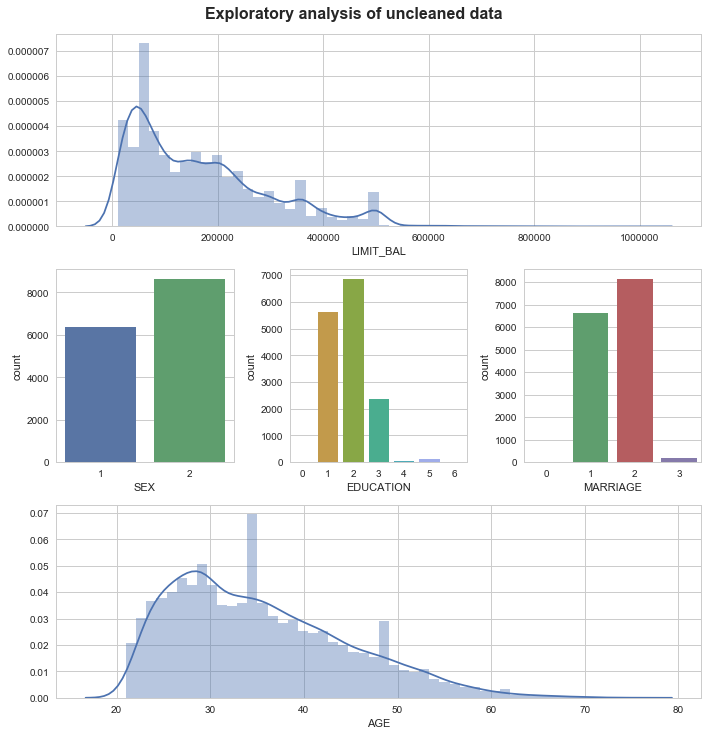

In [5]:
# examine distribution of values
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 3), (1, 0),)
ax3 = plt.subplot2grid((3, 3), (1, 1),)
ax4 = plt.subplot2grid((3, 3), (1, 2),)
ax5 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
sns.distplot(df.LIMIT_BAL,ax=ax1);
sns.countplot(df.SEX,ax=ax2)
sns.countplot(df.EDUCATION,ax=ax3)
sns.countplot(df.MARRIAGE,ax=ax4)
sns.distplot(df.AGE,ax=ax5);
plt.tight_layout()
plt.suptitle('Exploratory analysis of uncleaned data',y=1.02,fontsize=16,weight='bold')

### Insights
##### Handling categoricals
There are some categorical values which are not listed in the attribute information (e.g. EDUCATION 4, 5, MARRIAGE 3). Given 
than these are a relatively small fraction of the overall data, it makes sense to remove them rather than risk polluting data with approximated replacement values.
##### Continuous variables
Cutoffs of $500,000 for credit limit and 70 for age will be applied.
<hr>


### Feature simplification

In [6]:
# create dictionaries of the known data types,rename final column for ease of access by name
sexdict = {1:'Male',2:'Female'}
edudict = {1:'Grad School',2:'University',3:'High School'}
marriagedict = {1:'Married',2:'Single'}
df.rename(columns={'default payment next month':'default'},inplace=True)

In [7]:
# Filter the dataset to exclude undefined categorical values for education and marriage

edulist= [1,2,3]
marriagelist = [1,2]
df = df[df['EDUCATION'].isin(edulist)]
df = df[df['MARRIAGE'].isin(marriagelist)]

# Apply names from the dictionaries above
df.SEX = df.SEX.map(sexdict)
df.EDUCATION = df.EDUCATION.map(edudict)
df.MARRIAGE = df.MARRIAGE.map(marriagedict)

In [8]:
# Convert the continuous distributions of age and credit limit into binned values for ease of analysis and machine learning algorithms
agebins = np.arange(20,80,10)
agebinlabels = ['{}s'.format(i,j) for i,j in zip(agebins,agebins[1:])]
df['AGE_GROUP'] = pd.cut(df.AGE,bins=agebins,labels=agebinlabels,right=False)

creditlimitbins = np.arange(0,550000,50000)
creditbinlabels = ['{}-{}k'.format(i//1000,j//1000) for i,j in zip(creditlimitbins,creditlimitbins[1:])]
df['LIMIT_BAL_GROUP'] = pd.cut(df.LIMIT_BAL,bins=creditlimitbins,labels=creditbinlabels)

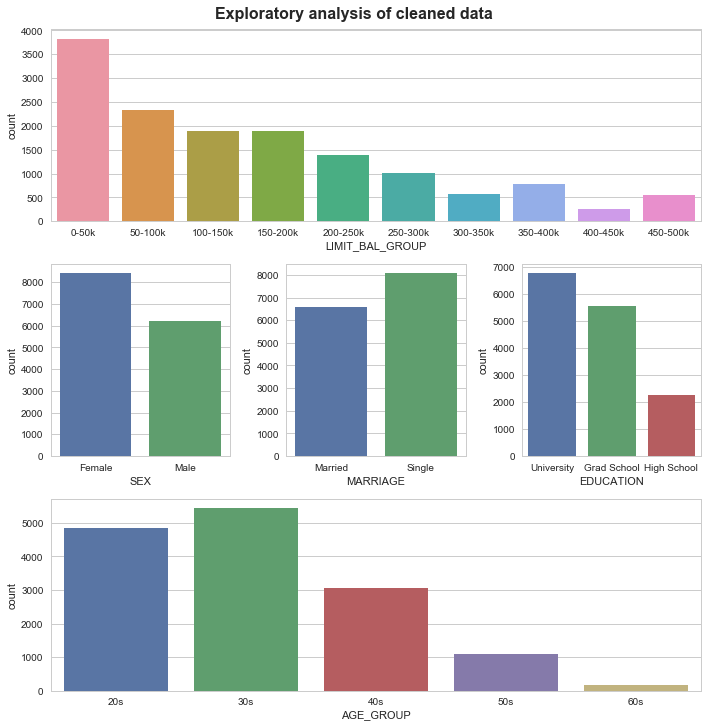

In [9]:
# examine distribution of values following data cleaning
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 3), (1, 0),)
ax3 = plt.subplot2grid((3, 3), (1, 1),)
ax4 = plt.subplot2grid((3, 3), (1, 2),)
ax5 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
plotlist=['LIMIT_BAL_GROUP','SEX','MARRIAGE','EDUCATION','AGE_GROUP']
for col,ax in zip(plotlist, fig.get_axes()):
    sns.countplot(x=col,data=df,ax=ax)
plt.suptitle('Exploratory analysis of cleaned data',y=1.01,fontsize=16,weight='bold')
plt.tight_layout()

The data is suitably clean to begin analysing for factors which contribute to default.
<HR>

## Section 2: Identification of factors

The pointplot is a useful tool to compare how variables affect the outcome (in this case, payment default).

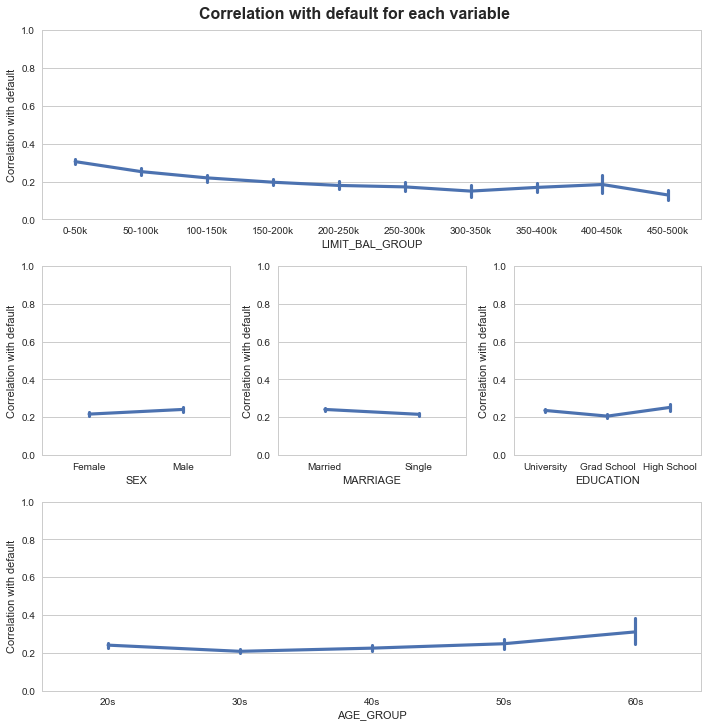

In [10]:
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 3), (1, 0), sharey=ax1)
ax3 = plt.subplot2grid((3, 3), (1, 1), sharey=ax1)
ax4 = plt.subplot2grid((3, 3), (1, 2), sharey=ax1)
ax5 = plt.subplot2grid((3, 3), (2, 0), colspan=3,sharey=ax1)
plotlist=['LIMIT_BAL_GROUP','SEX','MARRIAGE','EDUCATION','AGE_GROUP']
for col,ax in zip(plotlist, fig.get_axes()):
    sns.pointplot(x=col, y='default',data = df,ax=ax,markers='')
    ax.set_ylabel('Correlation with default')
ax1.set_ylim(0.0,1)
plt.suptitle('Correlation with default for each variable',y=1.01,fontsize=16,weight='bold')
plt.tight_layout()

### Insights
The categorical factors are quite weakly linked to the risk of default, with no single value weighting more than 0.4. However, there are a few insights that can be gleaned:

1) Risk of default is higher when the limit balance is lower

2) Risk of default is at a minimum for customers in their 30s

3) Highest risk: Married men with a high school education in their later years)

4) Lowest risk: Single women with a grad school education in their 30s

Next steps: Continue search for additional features which have a higher correlation with default.
<hr>

### History of past payment

History of past payment may be an indicator of the risk of default. We might expect a customer missing payments as an indicator that default may be about to occur. This analysis will examine how payment delay in previous periods is connected with risk of default.

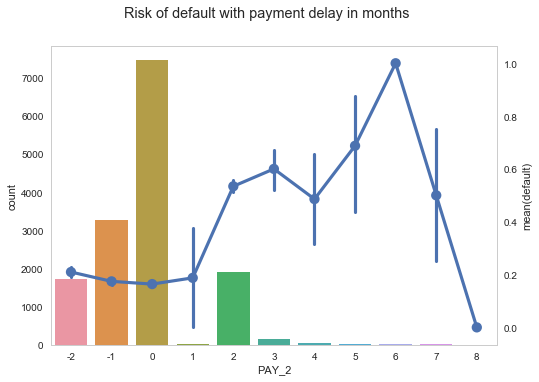

In [11]:
ax1 = sns.countplot(x='PAY_2',data=df)
ax2=ax1.twinx()
ax2 = sns.pointplot(x='PAY_2',y='default',data=df,zorder=10,ax=ax2)
ax1.grid(False)
ax2.grid(False)
plt.suptitle('Risk of default with payment delay in months');

### Insights
Payment codes of -2,-1 or 0 make up the majority of values (coloured bars), and they correlate with very low risk of default (blue dotted line). When there is a payment delay of 2 months or more (green bar), the risk of default jumps up significantly to ~0.5. 

There are very few datapoints for payment delays of 3 months or more. Therefore, a feature which links payment delays of <b>2 months or more</b> to risk of default may be useful in a predictive model. The next stage will investigate if a 2 month cut off is appropriate for the other pay periods too.

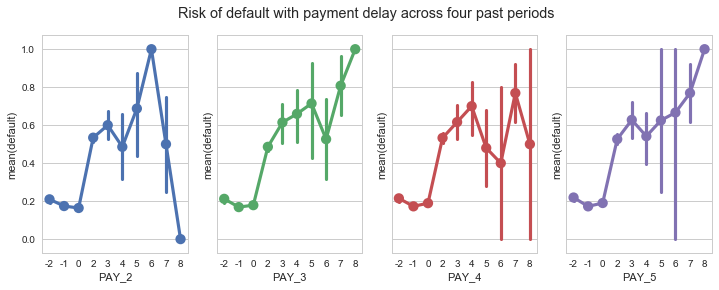

In [12]:
payment_delay_cols = ['PAY_2','PAY_3','PAY_4','PAY_5']
fig,ax=plt.subplots(1,4,figsize=(12,4),sharey=True)
for i,(column,ax) in enumerate(zip(payment_delay_cols,ax)):
    sns.pointplot(x=column,y='default',data=df[df[column]!=1],ax=ax,color=sns.color_palette()[i])
plt.suptitle('Risk of default with payment delay across four past periods');

Choice of cut off: 
- Assign a cut off of <b>2 months</b> for 'PAY_2', 'PAY_3', 'PAY_4', and 'PAY_5' columns
- Create a new feature (with 'TEST' suffix) for each of these columns.

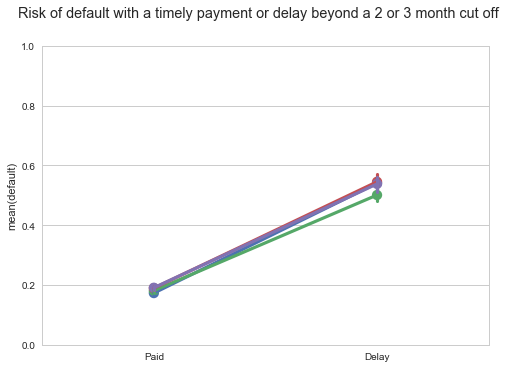

In [13]:
cutoff_point = {'PAY_2' : 2,'PAY_3' : 2,'PAY_4' : 2,'PAY_5':2}
for color,column in enumerate(cutoff_point.keys()):
    df[column+'_TEST'] =  df[column].map(lambda x: 'Delay' if x >= cutoff_point[column] else 'Paid')
    sns.pointplot(x=column+'_TEST',y='default',data=df,order=['Paid','Delay'],color=sns.color_palette()[color])
plt.xlabel('')
plt.ylim(0,1);
plt.suptitle('Risk of default with a timely payment or delay beyond a 2 or 3 month cut off');

### Insights
This feature engineering has produced four new features which have a much larger probability of identifying risk of default than the original personal data alone.

<hr>

## Section 3: Machine learning analysis

This section will prepare and analyse the data with machine learning algorithms. Analysis will occur firstly 

1) on the <b>personal data alone</b>, which would be available at the point where the credit is applied for.

2) on the <b> personal data plus the payment history</b>, which would become available over time.
 

In [53]:
# One-hot encoding to produce a sparse matrix suitable for input to sklearn
modeldata = df[['LIMIT_BAL_GROUP','AGE_GROUP','SEX','MARRIAGE','EDUCATION']]
X = pd.get_dummies(modeldata)
y = df.default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=31)

In [60]:
def compare4models():
    """ returns a figure based from four machine learning models"""
    
    names = ["Nearest Neighbors",
             "Linear SVM",
             "Decision Tree",
             "Naive Bayes"]

    classifiers = [KNeighborsClassifier(3),
                   SVC(kernel="linear", C=0.025),
                   DecisionTreeClassifier(max_depth=5),
                   GaussianNB()]
    
    cmaps = ['Reds',
             'Greens',
             'Blues',
             'Oranges']
    
    numrows = int(np.ceil(len(names)/2))
    fig,ax = plt.subplots(nrows=numrows,ncols=2,figsize=(10,numrows*5))

    
    for name,clf,ax,cmap in zip(names, classifiers,ax.ravel(),cmaps):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = clf.score(X_test, y_test)
        confmatrix = confusion_matrix(y_test,y_pred)
        true0,true1 = confmatrix[0]
        pred0,pred1 = confmatrix[1]
        ylabels=['Not default: '+str(true0), 'Default: {}'.format(true1)]
        xlabels=['Not default: {}'.format(pred0), 'Default: {}'.format(pred1)]
        sns.heatmap(confusion_matrix(y_test,y_pred),
                    annot=True,
                    xticklabels=xlabels,
                    yticklabels=ylabels,
                    fmt='g',
                    ax=ax,
                    vmax=len(X_test),
                    vmin=0,
                    cbar=False,
                    cmap=cmap)
        ax.set_xlabel('Truth')
        ax.set_ylabel('Predicted')
        ax.set_title('{} (Score: {})'.format(name,np.round(score,decimals=3)),size=14)
    return fig

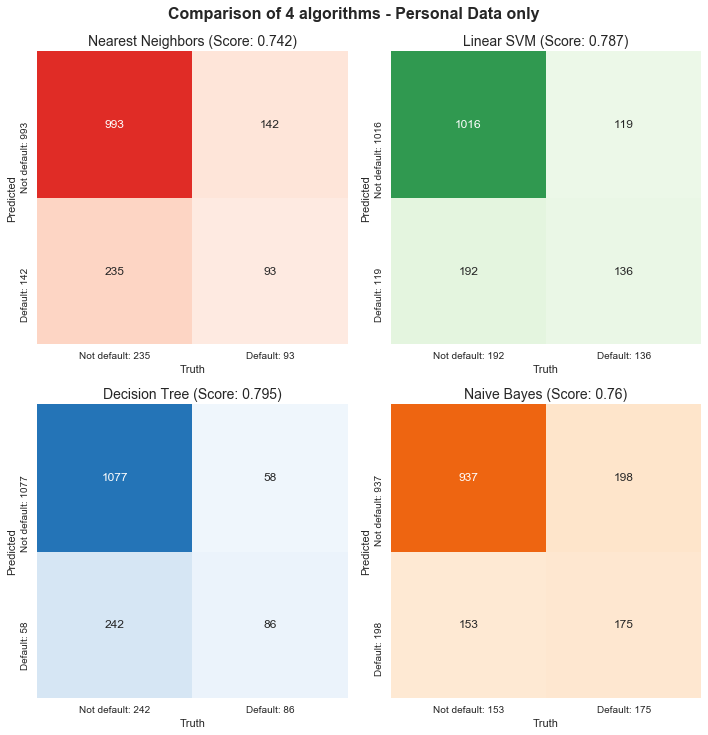

In [61]:
compare4models()
plt.suptitle('Comparison of 4 algorithms - Personal Data only', y=1.02,size=16,weight='bold')
plt.tight_layout()

In [62]:
# One-hot encoding to produce a sparse matrix suitable for input to sklearn
# Add extra columns with payment history data
modeldata = df[['LIMIT_BAL_GROUP','AGE_GROUP','SEX','MARRIAGE','EDUCATION',
                'PAY_2_TEST','PAY_3_TEST','PAY_4_TEST','PAY_5_TEST']]
X = pd.get_dummies(modeldata)
y = df.default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=31)

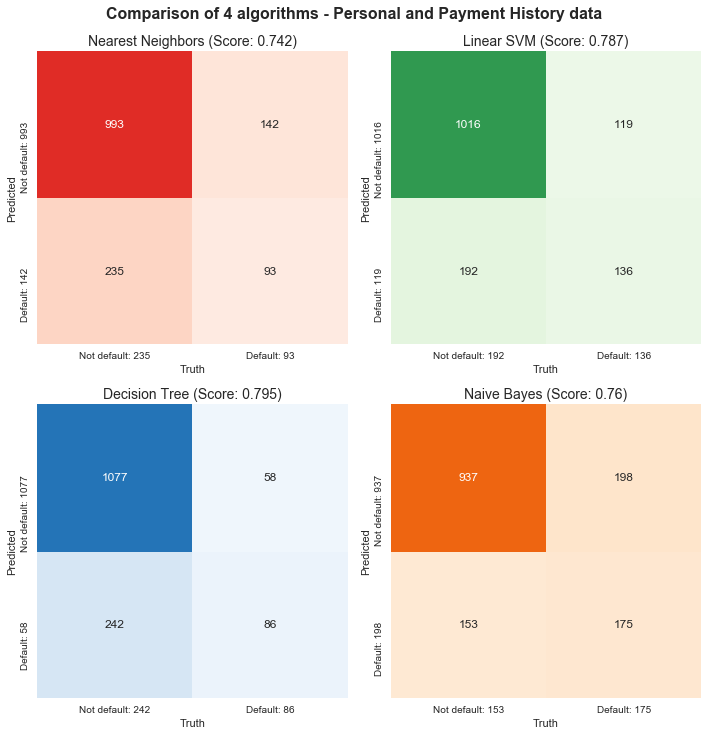

In [63]:
compare4models()
plt.suptitle('Comparison of 4 algorithms - Personal and Payment History data', y=1.02,size=16,weight='bold')
plt.tight_layout()